100%|██████████| 400/400 [12:27<00:00,  1.87s/it]

Segment lengths: min 0.013, max 0.017
Curvature: min 0.000, max 0.000


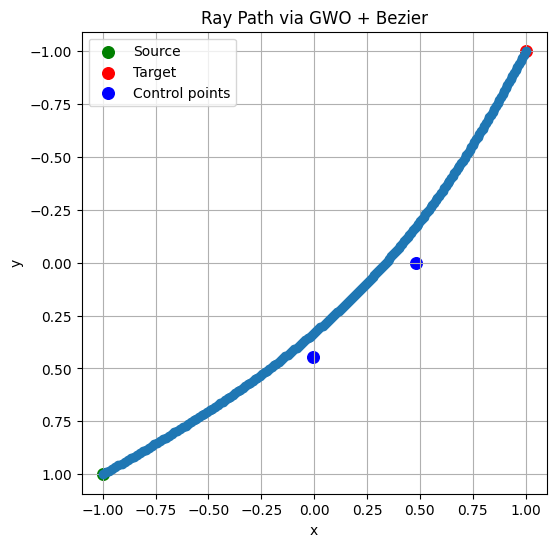

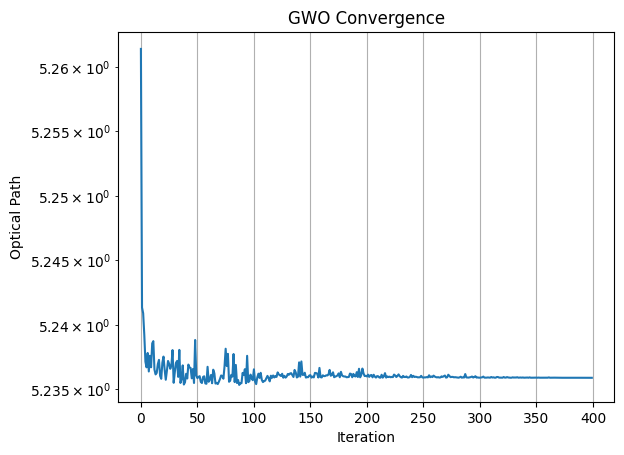

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from GWO.GWO_optimizer import GWOOptimizer

device = "cuda" if torch.cuda.is_available() else "cpu"

# -----------------------------
# Geometry
# -----------------------------
A = torch.tensor([-1.0, 1.0], device=device)
B = torch.tensor([1.0, -1.0], device=device)

# Number of intermediate control points (Bezier)
num_ctrl = 2  

# Number of points to sample curve for cost computation
num_samples = 200

# -----------------------------
# Refractive index field
# -----------------------------
def refractive_index(p):
    y = p[1]
    return 1.0 + 0.8 * torch.exp(-0.8 * y)  # example graded index

# -----------------------------
# Bezier curve helper
# -----------------------------
def cubic_bezier(t, P0, P1, P2, P3):
    return (1-t)**3 * P0 + 3*(1-t)**2*t*P1 + 3*(1-t)*t**2*P2 + t**3*P3

def sample_bezier(ctrl_points, num_points):
    P0 = A
    P1 = ctrl_points[0]
    P2 = ctrl_points[1]
    P3 = B
    ts = torch.linspace(0,1,num_points, device=device)
    curve = torch.stack([cubic_bezier(t,P0,P1,P2,P3) for t in ts])
    return curve

# -----------------------------
# Objective function for GWO
# -----------------------------
def optical_path_bezier(flat_ctrl):
    # reshape to control points
    ctrl_points = []
    for i in range(num_ctrl):
        ctrl_points.append(torch.stack([flat_ctrl[2*i], flat_ctrl[2*i+1]]))
    # sample curve
    curve = sample_bezier(ctrl_points, num_samples)
    # compute discrete optical path
    cost = 0.0
    for i in range(num_samples-1):
        p = curve[i]
        q = curve[i+1]
        ds = torch.norm(q-p)
        n_mid = refractive_index(0.5*(p+q))
        cost += n_mid * ds
    return cost

# -----------------------------
# Bounds for control points
# -----------------------------
bounds = []
for _ in range(num_ctrl):
    bounds.append((-2.0, 2.0))  # x
    bounds.append((-2.0, 2.0))  # y

# -----------------------------
# Initial guess (linear)
# -----------------------------
xs = np.linspace(A[0].item(), B[0].item(), num_ctrl+2)[1:-1]
ys = np.linspace(A[1].item(), B[1].item(), num_ctrl+2)[1:-1]
init = []
for x,y in zip(xs,ys):
    init.append(x)
    init.append(y)
initial_guess = torch.tensor(init, device=device)

# -----------------------------
# GWO optimizer
# -----------------------------
optimizer = GWOOptimizer(
    objective_function=optical_path_bezier,
    bounds=bounds,
    population_size=30,
    max_iter=400,
    device=device
)

best_solution, loss_curve = optimizer.optimize()

# -----------------------------
# Reconstruct smooth curve
# -----------------------------
ctrl_points = []
for i in range(num_ctrl):
    ctrl_points.append(torch.stack([best_solution[2*i], best_solution[2*i+1]]))
curve_pts = sample_bezier(ctrl_points, num_samples)
curve_np = curve_pts.cpu().numpy()

# -----------------------------
# Debug: segment lengths and curvature
# -----------------------------
seg_lengths = [np.linalg.norm(curve_np[i+1]-curve_np[i]) for i in range(len(curve_np)-1)]
curvature_vals = [np.linalg.norm(curve_np[i+1]-2*curve_np[i]+curve_np[i-1]) for i in range(1,len(curve_np)-1)]

print("Segment lengths: min {:.3f}, max {:.3f}".format(min(seg_lengths), max(seg_lengths)))
print("Curvature: min {:.3f}, max {:.3f}".format(min(curvature_vals), max(curvature_vals)))

# -----------------------------
# Plots
# -----------------------------
plt.figure(figsize=(6,6))
plt.plot(curve_np[:,0], curve_np[:,1], "-o", lw=2)
plt.scatter(A[0].cpu(), A[1].cpu(), c="green", s=70, label="Source")
plt.scatter(B[0].cpu(), B[1].cpu(), c="red", s=70, label="Target")
# optional: plot control points
ctrl_np = np.array([p.cpu().numpy() for p in ctrl_points])
plt.scatter(ctrl_np[:,0], ctrl_np[:,1], c="blue", s=70, label="Control points")
plt.title("Ray Path via GWO + Bezier")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.grid(True)
plt.legend()
plt.gca().invert_yaxis()
plt.show()

# Convergence
plt.figure()
plt.plot(loss_curve)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Optical Path")
plt.title("GWO Convergence")
plt.grid(True)
plt.show()
